# DOMAIN GENERATION ALGORITHM (DGA) DETECTION 

This dataset has been collected from Alexa website ranking a blacklist of previous DGA domain names both sources are avaiblable within the provenance section.
The purpose is to build a classifier which can help us detect a potential machine infected by the DGA (Domain Generation Algorithm) malware.
Typically machines that are infected tend to generate a bunch of random domain names which will contain one active C&C server.

In [60]:
# Data wrangling and analysis libries
import numpy as np 
import pandas as pd 
import warnings 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split

# libraries for preprocessing
import pickle
import tldextract as xt 
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# libraries for ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, f1_score, precision_score

# set parameters
pd.set_option('display.max_rows', 5)
warnings.filterwarnings(action='ignore')
%matplotlib inline

## Data Gathering

In [2]:
import os
pwd = os.getcwd()
data_path = os.path.join(pwd,'dataset/dga_data.csv')  #pth to dataset
data = pd.read_csv(data_path)
df = data.copy()
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


## EDA

In [3]:
#get the shape of the entire dataset 
print(f'The dataset contains {df.shape[1]} features, {df.shape[0]} instances')
for columns,count in zip(df.columns, range(1,len(df.columns)+1)):
    print(f'Feature {count}: {columns}')

The dataset contains 4 features, 160000 instances
Feature 1: isDGA
Feature 2: domain
Feature 3: host
Feature 4: subclass


In [4]:
df.describe()

,isDGA,domain,host,subclass
count,160000,159998,160000,160000
unique,2,159998,159235,9
top,dga,6xzxsw3sokvg1tc752y1a6p0af,ventures-africa.com,alexa
freq,80000,1,2,42616


Description of features 
-  The 'isDGA' feature consists of the categorical values representing the binary class with a frequency of 80k for each value of the binary class 
- The 'domain' column contains unique domain names having a frequency of 1
-  The 'host' column contains the complete unique domain names including its prefixes
-  The 'subclass' column contains the sub classes names represnting the family of DGA maleware the domain belongs to    

Cardinality of unique values

In [5]:
categorical_variables = ['isDGA','subclass']
descrete_variables = ['domain','host']

isDGA has 2 unique categories : ['dga' 'legit']
subclass has 9 unique categories : ['gameoverdga' 'cryptolocker' 'newgoz' 'nivdort' 'goz' 'necurs' 'bamital'
 'legit' 'alexa']


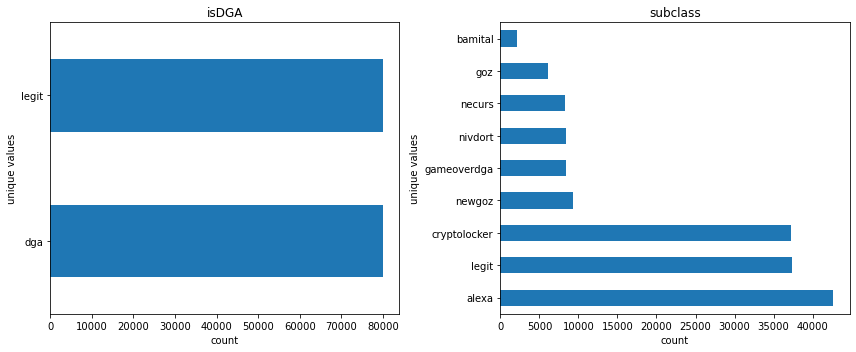

In [6]:
plt.figure(figsize=(12,5))
for column, count in zip(categorical_variables, range(1,3)):
    plt.subplot(1,2, count)
    print(f'{column} has {len(df[column].unique())} unique categories : {df[column].unique()}')
    df[column].value_counts().plot.barh()
    plt.title(column)
    plt.xlabel('count')
    plt.ylabel('unique values')
    plt.tight_layout()
plt.show()

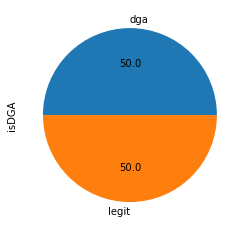

In [7]:
# distribution of count of binary class
df['isDGA'].value_counts().plot.pie(autopct='%.1f')
plt.show()

Find missing valuse for each column in dataset

In [8]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0] #list comprehension to store features with missing values 
for feature in features_with_na:
    print(f'The Column - "{feature}" has {np.round((df[feature].isnull().mean())*100, 3)}% of missing values') #print % of missing values 
print('This will be handled in the feature engineering section')

The Column - "domain" has 0.001% of missing values
This will be handled in the feature engineering section


group and compare the binary domain class with the subclass

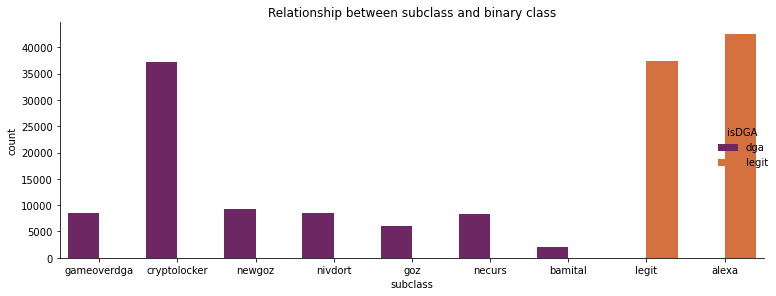

In [9]:
df1 = df.copy()
sns.catplot(hue='isDGA', x='subclass',
            data=df1, kind='count', palette='inferno', height=4.0, aspect=2.5, orient="v")
plt.tight_layout()
plt.title('Relationship between subclass and binary class')
plt.show()

In [10]:
# unique domain classes - 9
domain_classes = ['gameoverdga', 'cryptolocker', 'newgoz', 'nivdort', 'goz',
       'necurs', 'bamital', 'legit', 'alexa']

# create dataframe of two samples of data based on maleware family to find relationhips  
container = [] 
for domain_type in domain_classes:
    res = df[df['subclass'] == f'{domain_type}'].iloc[:4,:]
    display(res) # display dataframe

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
18,dga,1rw1pc44mkxp4qjx18qua26,1rw1pc44mkxp4qjx18qua26.net,gameoverdga
21,dga,1x75xo41t4fno51wc86e1y4s13d,1x75xo41t4fno51wc86e1y4s13d.net,gameoverdga
23,dga,1y6oppp7k3pwfpo2sfmkloyxa,1y6oppp7k3pwfpo2sfmkloyxa.biz,gameoverdga


,isDGA,domain,host,subclass
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker
6,dga,vrrtneoswsds,vrrtneoswsds.ru,cryptolocker


,isDGA,domain,host,subclass
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
7,dga,mzapiwbcsbqiyxnlxa1hprx8n,mzapiwbcsbqiyxnlxa1hprx8n.com,newgoz
17,dga,n3m4txqpb6a415iwzkrmdzgk6,n3m4txqpb6a415iwzkrmdzgk6.com,newgoz
37,dga,wawft814u5se21tmptb51yy47q2,wawft814u5se21tmptb51yy47q2.org,newgoz


,isDGA,domain,host,subclass
5,dga,takenroll,takenroll.net,nivdort
9,dga,dreamdont,dreamdont.net,nivdort
10,dga,visitshot,visitshot.net,nivdort
22,dga,mostjune,mostjune.net,nivdort


,isDGA,domain,host,subclass
13,dga,rcdqeqmpxgdiuqombhuwcfu,rcdqeqmpxgdiuqombhuwcfu.ru,goz
52,dga,jrxrovxkbemgqutopblbbfe,jrxrovxkbemgqutopblbbfe.ru,goz
55,dga,dixnzhelzukwsojfxuivlamadu,dixnzhelzukwsojfxuivlamadu.ru,goz
84,dga,ydhmbyhgypnkdpzcymnnjxcalfm,ydhmbyhgypnkdpzcymnnjxcalfm.ru,goz


,isDGA,domain,host,subclass
27,dga,sfmbdpnijlarq,sfmbdpnijlarq.cc,necurs
28,dga,vdqqfdcax,vdqqfdcax.im,necurs
33,dga,njtvrfhfaklho,njtvrfhfaklho.sc,necurs
53,dga,hsmcnwof,hsmcnwof.mx,necurs


,isDGA,domain,host,subclass
259,dga,5df9d44072820ad6eaac91669f357fea,5df9d44072820ad6eaac91669f357fea.org,bamital
322,dga,a7fd378e8e64200f13421e6135a06dce,a7fd378e8e64200f13421e6135a06dce.org,bamital
358,dga,dd82f8a0b2b6520e2706f704ba2a289a,dd82f8a0b2b6520e2706f704ba2a289a.org,bamital
414,dga,08c9bb43ca6555de477ec262b078cb91,08c9bb43ca6555de477ec262b078cb91.org,bamital


,isDGA,domain,host,subclass
80000,legit,zige365,zige365.com,legit
80001,legit,sportswiki,sportswiki.ru,legit
80003,legit,meuslinks,meuslinks.com,legit
80004,legit,atskype,atskype.jp,legit


,isDGA,domain,host,subclass
80002,legit,clutchfans,clutchfans.net,alexa
80005,legit,marykayintouch,marykayintouch.com,alexa
80006,legit,droid,droid-life.com,alexa
80007,legit,polimi,polimi.it,alexa


From the exploring the dataset and making analysis, the following was observed; 
- The 'isDGA' column has unique binary class values of 'dga' & 'legit' which has a balanced distribution for training purpose
- The 'subclass' column has multiple classes but pocesses an unbalanced distribution which is not fit for training purposes - [this will be handled in feature engineering section]
- The 0.001% amount of null/missing values in the dataset is quite insignificant as it will not have much impact if eleiminated from the dataset with reference to the original size of the dataset
- Relating the binary class and the subclasses together shows that the 'alexa' & 'legit' subclasses are categorized under the 'legit' class while the rest of the subclasses fall under the DGA maleware family 

## FEATURE ENGINEERING & FEATURE SELECTION FOR BINARY CLASS - legit | dga

Handle 0.001% null values 

In [11]:
df = df.dropna(axis=0)
df.describe()

,isDGA,domain,host,subclass
count,159998,159998,159998,159998
unique,2,159998,159234,9
top,dga,6xzxsw3sokvg1tc752y1a6p0af,constant-content.com,alexa
freq,80000,1,2,42614


In [41]:
# preprocessing helper functions

# containers to keep track of encoded values
mapping = list() 
mapping_test = list()

mapping_multi = list() 
mapping_multi_test = list()

# function to encode target varibles
def encode_feature(data, map):
    le = LabelEncoder()
    features = le.fit_transform(data)
    mappings_dict = {index: label for index, label in enumerate(le.classes_)}
    map.append(mappings_dict)
    return features

# helper function
def join_char(s):
    str1 = ''
    return(str1.join(s))

# function to perform n_grams on input string 
def n_gram_extraction(n, token):
    lst = []
    n_grams = ngrams(list(str(token)), n)
    for items in n_grams:
        res = join_char(list(items))
        
        lst.append(res)
    return lst

# function to tokenize input url and extract values to form unigrams, bigrams & trigrams 
def tokenizer(url):
    # break url to domain, subdomain & suffix 

    # full url token - domain + subdomain + suffix
    url_token = f'{url}-{xt.extract(url).subdomain}-{xt.extract(url).domain}-{xt.extract(url).suffix}'
    
    # url to unigram level
    domain_unigram = n_gram_extraction(1,xt.extract(url).domain)
    subdomain_unigram = n_gram_extraction(1,xt.extract(url).subdomain)

    # url to bigram level
    domain_bigram = n_gram_extraction(2,xt.extract(url).domain)
    subdomain_bigram = n_gram_extraction(2,xt.extract(url).subdomain)

    # url to trigram level
    domain_trigram = n_gram_extraction(3,xt.extract(url).domain)
    subdomain_trigram = n_gram_extraction(3,xt.extract(url).subdomain)
    token = url_token.split('-')
    if '' in token:
        token.remove('') # remove empty element in list
    
    # append final exteacted tokens to list to form extracted features
    for item in domain_unigram:
        token.append(item)
    for item in subdomain_unigram:
        token.append(item)

    for item in domain_bigram:
        token.append(item)
    for item in domain_trigram:
        token.append(item)

    for item in subdomain_bigram:
        token.append(item)
    for item in subdomain_trigram:
        token.append(item)

    # print(token)

    return token

In [13]:
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


- The most important column for feature extraction is 'host' as it contains the full version of the unique domain names including the suffixes which provides additional information 
- The 'isDGA' columns is used to as target column for purpose of binary classification model

For Binary class

In [61]:
#split data - 80 : 20 Ratio 
X_val = df['host']
y_val = df['isDGA']
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=.2, random_state=0)
print(f'X_train size : {X_train.shape} | X_test size: {X_test.shape}')
print(f'X_train size : {y_train.shape} | X_test size: {y_test.shape}')

X_train size : (127998,) | X_test size: (32000,)
X_train size : (127998,) | X_test size: (32000,)


In [62]:
with open('models/Xtrain.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [43]:
y_train_encode = encode_feature(y_train, map=mapping)
y_test_encode = encode_feature(y_test, map=mapping_test)
y_train_encode

array([1, 0, 0, ..., 1, 1, 0])

In [16]:
mapping

[{0: 'dga', 1: 'legit'}]

For multi-class

In [44]:
test_token = X_train[3]
token = tokenizer(test_token)
for i in list(dict.fromkeys(test_token)):
  print("{} - {}".format(test_token.count(i), i))

2 - z
1 - f
1 - d
2 - 5
1 - s
1 - p
2 - i
2 - 1
2 - 8
1 - w
1 - j
2 - 9
1 - u
1 - y
1 - 3
1 - l
1 - 6
1 - r
1 - g
1 - .
1 - n
1 - e
1 - t


In [45]:
example_cVec = CountVectorizer(tokenizer=tokenizer)
example_X = example_cVec.fit_transform([test_token])

print("\n- Count Vectorizer (Test URL) -\n")
print(example_X)

print()
print("=" * 50)
print()

example_tVec = TfidfVectorizer(tokenizer=tokenizer)
example_X = example_tVec.fit_transform([test_token])

print("\n- TFIDF Vectorizer (Test URL) -\n")
print(example_X)


- Count Vectorizer (Test URL) -

  (0, 66)	1
  (0, 65)	1
  (0, 44)	1
  (0, 62)	2
  (0, 29)	1
  (0, 26)	1
  (0, 8)	2
  (0, 50)	1
  (0, 45)	1
  (0, 33)	2
  (0, 0)	2
  (0, 16)	2
  (0, 56)	1
  (0, 38)	1
  (0, 21)	2
  (0, 53)	1
  (0, 59)	1
  (0, 5)	1
  (0, 41)	1
  (0, 13)	1
  (0, 48)	1
  (0, 32)	1
  (0, 63)	1
  (0, 30)	1
  (0, 27)	1
  :	:
  (0, 22)	1
  (0, 49)	1
  (0, 64)	1
  (0, 31)	1
  (0, 28)	1
  (0, 10)	1
  (0, 52)	1
  (0, 68)	1
  (0, 47)	1
  (0, 35)	1
  (0, 4)	1
  (0, 20)	1
  (0, 37)	1
  (0, 18)	1
  (0, 12)	1
  (0, 58)	1
  (0, 40)	1
  (0, 25)	1
  (0, 55)	1
  (0, 61)	1
  (0, 2)	1
  (0, 7)	1
  (0, 43)	1
  (0, 15)	1
  (0, 23)	1



- TFIDF Vectorizer (Test URL) -

  (0, 23)	0.10721125348377948
  (0, 15)	0.10721125348377948
  (0, 43)	0.10721125348377948
  (0, 7)	0.10721125348377948
  (0, 2)	0.10721125348377948
  (0, 61)	0.10721125348377948
  (0, 55)	0.10721125348377948
  (0, 25)	0.10721125348377948
  (0, 40)	0.10721125348377948
  (0, 58)	0.10721125348377948
  (0, 12)	0.10721125348377948
  

In [46]:
print("- Training Count Vectorizer -")
cVec = CountVectorizer(tokenizer=tokenizer)
count_X = cVec.fit_transform(X_train)
print('count vec complete.......')

print("- Training TF-IDF Vectorizer -")
tVec = TfidfVectorizer(tokenizer=tokenizer)
tfidf_X = tVec.fit_transform(X_train)
print('TF-IDF vec complete.......')

- Training Count Vectorizer -
count vec complete.......
- Training TF-IDF Vectorizer -
TF-IDF vec complete.......


In [47]:
count_X.shape

(127998, 300680)

In [21]:
# Test Vectorizers
print("- Count Vectorizer -")
test_count_X = cVec.transform(X_test)

print("- TFIDF Vectorizer -")
test_tfidf_X = tVec.transform(X_test)


print("\n### Vectorizing Complete ###\n")

- Count Vectorizer -
- TFIDF Vectorizer -

### Vectorizing Complete ###



# MODEL BUILDING

In [98]:
#ML models i would use to train my data 
models = { 'RandomForestClassifier' : RandomForestClassifier(max_depth=100, random_state=42),
           'LogisticRegression'  : LogisticRegression(random_state=42),
           'MLPClassifier' : MLPClassifier(random_state=42, max_iter=300),
}

In [99]:
label = ['dga','legit']

Training for count vectorizer

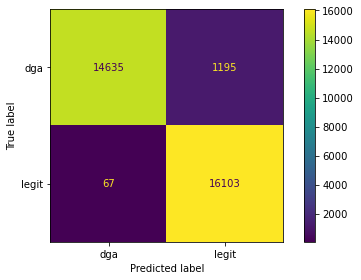

RandomForestClassifier
   accuracy_score  f1_score  precision_score  recall_score
0        0.960562  0.962292         0.930917      0.995857
##################################################


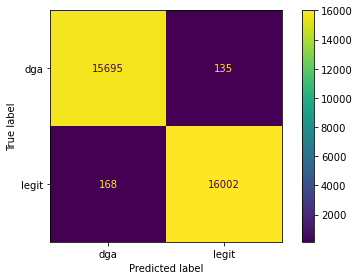

LogisticRegression
   accuracy_score  f1_score  precision_score  recall_score
0        0.990531  0.990621         0.991634       0.98961
##################################################


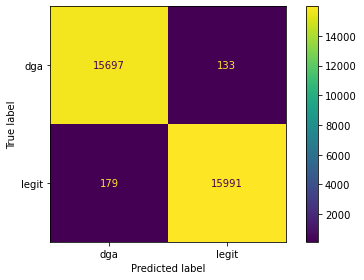

MLPClassifier
   accuracy_score  f1_score  precision_score  recall_score
0         0.99025  0.990339         0.991751       0.98893
##################################################


In [100]:
for name, model in models.items():
  model.fit(count_X,y_train_encode)
  pred = model.predict(test_count_X)
  score = accuracy_score(y_test_encode,pred)
  recall = recall_score(y_test_encode, pred)
  f1 = f1_score(y_test_encode, pred)
  precision = precision_score(y_test_encode, pred)



  cm = confusion_matrix(y_test_encode, pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
  
  disp.plot()
  plt.tight_layout()
  plt.show()
  

  data_frame = {'accuracy_score': score,'f1_score':f1,'precision_score':precision,
        'recall_score':recall}
  result_data = pd.DataFrame(data=data_frame, index=[0])
  print(name)
  print(result_data)
  print('#' *50)

Training for TFIDF vectorizer

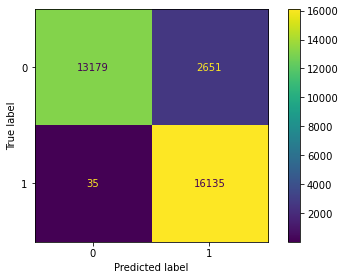

RandomForestClassifier
   accuracy_score  f1_score  precision_score  recall_score
0        0.916063  0.923161         0.858884      0.997835
##################################################


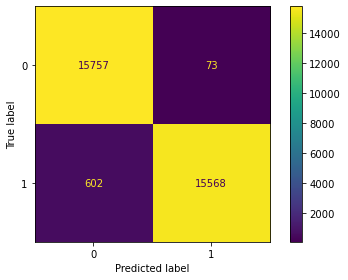

LogisticRegression
   accuracy_score  f1_score  precision_score  recall_score
0        0.978906  0.978781         0.995333      0.962771
##################################################


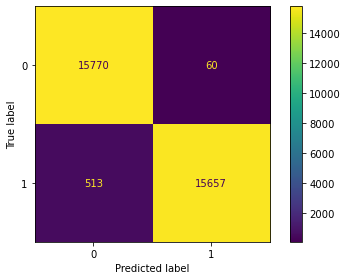

MLPClassifier
   accuracy_score  f1_score  precision_score  recall_score
0        0.982094   0.98203         0.996182      0.968275
##################################################


In [101]:
for name, model in models.items():
  model.fit(tfidf_X,y_train_encode)
  pred = model.predict(test_tfidf_X)
  score = accuracy_score(y_test_encode,pred)
  recall = recall_score(y_test_encode, pred)
  f1 = f1_score(y_test_encode, pred)
  precision = precision_score(y_test_encode, pred)

  cm = confusion_matrix(y_test_encode, pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
  disp.plot()
  plt.tight_layout()
  plt.show()

  data_frame = {'accuracy_score': score,'f1_score':f1,'precision_score':precision,
        'recall_score':recall}
  result_data = pd.DataFrame(data=data_frame, index=[0])
  print(name)
  print(result_data)
  print('#' *50)

Training with Random forest with TFIDF vectoriorizer

In [22]:
rf_model = RandomForestClassifier(max_depth=100, random_state=42)
rf_model.fit(tfidf_X,y_train_encode)

RandomForestClassifier(max_depth=100, random_state=42)

In [23]:
#saving the trained model state
import joblib 

file_name = 'models/trained_rf_dga_classifier.sav'
joblib.dump(rf_model, filename=file_name)

['models/trained_rf_dga_classifier.sav']